In [1]:
# CELL 2 - Imports
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (8,5)
print('Imports ready')


Imports ready


In [2]:
# CELL 3 - Paths & Load datasets
student_path = os.path.join('student.csv')
prop_path = os.path.join('proportion_df.csv')
asia_path = os.path.join('Asia_cost_components.csv')

print('Expecting files at:', student_path, prop_path, asia_path)

student = pd.DataFrame()
proportion_df = pd.DataFrame()
asia = pd.DataFrame()

if os.path.exists(student_path):
    student = pd.read_csv(student_path)
    print('Loaded student.csv ->', student.shape)
else:
    print('student.csv NOT FOUND at', student_path)

if os.path.exists(prop_path):
    proportion_df = pd.read_csv(prop_path)
    print('Loaded proportion_df.csv ->', proportion_df.shape)
else:
    print('proportion_df.csv NOT FOUND at', prop_path)

if os.path.exists(asia_path):
    asia = pd.read_csv(asia_path)
    print('Loaded Asia_cost_components.csv ->', asia.shape)
else:
    print('Asia_cost_components.csv NOT FOUND at', asia_path)

# preview if available
if not student.empty:
    display(student.head())
if not proportion_df.empty:
    display(proportion_df.head())
if not asia.empty:
    display(asia.head())


Expecting files at: student.csv proportion_df.csv Asia_cost_components.csv
Loaded student.csv -> (1000, 18)
Loaded proportion_df.csv -> (215, 14)
Loaded Asia_cost_components.csv -> (12, 2)


,id,age,gender,year_in_school,major,monthly_income,financial_aid,tuition,housing,food,transportation,books_supplies,entertainment,personal_care,technology,health_wellness,miscellaneous,preferred_payment_method
0,0,19,Non-binary,Freshman,Psychology,958,270,5939,709,296,123,188,41,78,134,127,72,Credit/Debit Card
1,1,24,Female,Junior,Economics,1006,875,4908,557,365,85,252,74,92,226,129,68,Credit/Debit Card
2,2,24,Non-binary,Junior,Economics,734,928,3051,666,220,137,99,130,23,239,112,133,Cash
3,3,23,Female,Senior,Computer Science,617,265,4935,652,289,114,223,99,30,163,105,55,Mobile Payment App
4,4,20,Female,Senior,Computer Science,810,522,3887,825,372,168,194,48,71,88,71,104,Credit/Debit Card


,country,Meals,Drinks,Groceries,Fruits and Vegetables,Market Items,Cigarettes,Transport,Utilities,Entertainment and Education,Clothing and Shoes,Housing,Mortgage,Total Cost of Living
0,Afghanistan,0.039898,0.007850,0.051336,0.014913,0.017161,0.004738,93.245238,1.183770,2.277990,0.205501,2.922573,0.029031,19278.103333
1,Albania,0.111657,0.023853,0.071718,0.020002,0.025432,0.009370,88.271643,0.314625,5.447603,0.645603,5.045751,0.012742,30643.274000
2,Algeria,0.042249,0.009918,0.050468,0.017852,0.018566,0.004746,93.432349,0.164455,2.518639,0.376690,3.357345,0.006724,41814.766176
3,American Samoa,19.538010,3.405504,10.959260,2.740743,0.000000,0.000000,0.000000,30.133323,0.000000,0.000000,33.223159,0.000000,269.270000
4,Andorra,0.263908,0.043565,0.152736,0.054679,0.033602,0.025410,27.511093,0.484295,13.556172,1.571413,56.290847,0.012280,23153.266667


,Cost Component,Proportion
0,Transport,80.220990
1,Entertainment and Education,10.803350
2,Housing,8.188633
3,Clothing and Shoes,0.390333
4,Utilities,0.198316


In [3]:
# CELL 4 - Compute Indonesia scale ratio from proportion_df
if proportion_df.empty:
    print('proportion_df is empty. Please provide the CSV file and re-run')
else:
    proportion_df.columns = [c.strip() for c in proportion_df.columns]
    total_col_candidates = [c for c in proportion_df.columns if 'total' in c.lower() and 'cost' in c.lower()]
    if not total_col_candidates:
        total_col_candidates = [c for c in proportion_df.columns if 'total' in c.lower()]
    if not total_col_candidates:
        raise ValueError('Tidak dapat menemukan kolom Total Cost of Living di proportion_df.csv. Kolom yang tersedia: ' + str(list(proportion_df.columns)))
    total_col = total_col_candidates[0]
    print('Using total cost column:', total_col)

    country_col = None
    for c in proportion_df.columns[:4]:
        if 'country' in c.lower():
            country_col = c
            break
    if country_col is None:
        country_col = proportion_df.columns[0]
    print('Using country column:', country_col)

    # ensure numeric
    proportion_df[total_col] = pd.to_numeric(proportion_df[total_col], errors='coerce')

    global_avg = proportion_df[total_col].mean()
    indonesia_row = proportion_df[proportion_df[country_col].str.lower()=='indonesia']
    if indonesia_row.shape[0]==0:
        indonesia_row = proportion_df[proportion_df[country_col].str.contains('indonesia', case=False, na=False)]
    if indonesia_row.shape[0]==0:
        print('Warning: Indonesia row not found in proportion_df. Using scale_ratio = 1.0')
        scale_ratio = 1.0
    else:
        indo_value = indonesia_row[total_col].iloc[0]
        scale_ratio = float(indo_value) / float(global_avg) if global_avg>0 else 1.0

    print('Global avg total cost:', global_avg)
    print('Indonesia total cost value:', indonesia_row[total_col].iloc[0] if indonesia_row.shape[0]>0 else 'N/A')
    print('Computed scale_ratio (Indonesia/global_avg) =', scale_ratio)


Using total cost column: Total Cost of Living
Using country column: country
Global avg total cost: 52244.667515594236
Indonesia total cost value: 44962.557
Computed scale_ratio (Indonesia/global_avg) = 0.8606152386093636


In [4]:
# CELL 5 - Prepare Asia baseline mapping to 5 categories
if asia.empty:
    print('asia dataframe is empty - please provide Asia_cost_components.csv')
else:
    if 'Cost Component' in asia.columns and 'Proportion' in asia.columns:
        asia_map = asia.set_index('Cost Component')['Proportion'].to_dict()
    else:
        asia_map = {str(r[0]): float(r[1]) for r in asia.values}

    def get_asia(k):
        return asia_map.get(k, 0.0)

    asia_baseline = {}
    asia_baseline['food'] = get_asia('Meals') + get_asia('Drinks') + get_asia('Groceries') + get_asia('Fruits and Vegetables') + get_asia('Market Items')
    asia_baseline['transport'] = get_asia('Transport')
    asia_baseline['entertainment'] = get_asia('Entertainment and Education')
    asia_baseline['laundry'] = get_asia('Utilities') * 0.05
    others_sum = asia_baseline['food'] + asia_baseline['transport'] + asia_baseline['entertainment'] + asia_baseline['laundry']
    asia_baseline['savings'] = max(0.0, 100.0 - others_sum)

    total = sum(asia_baseline.values())
    if total == 0:
        asia_baseline_frac = {k: 1/5 for k in asia_baseline}
    else:
        asia_baseline_frac = {k: asia_baseline[k]/total for k in asia_baseline}
    print('Asia baseline fractions (food,transport,entertainment,laundry,savings):')
    print(asia_baseline_frac)


Asia baseline fractions (food,transport,entertainment,laundry,savings):
{'food': 0.0017757081110704358, 'transport': 0.8022098980780038, 'entertainment': 0.108033498622181, 'laundry': 9.915782923255255e-05, 'savings': 0.08788173735951219}


In [5]:
# CELL 6 - Scale student dataset to Indonesia context and create targets
if student.empty:
    print('student is empty; please provide student.csv')
else:
    student = student.copy()
    student.columns = [c.strip().lower() for c in student.columns]

    # detect income
    income_col = None
    for c in student.columns:
        if 'income' in c:
            income_col = c
            break
    if income_col is None:
        raise ValueError('Tidak menemukan kolom income di student.csv')

    def safe_col(df, candidates, fallback=0):
        for cand in candidates:
            if cand in df.columns:
                return df[cand].fillna(0)
        return pd.Series(fallback, index=df.index)

    student['s_food'] = safe_col(student, ['food','meals'])
    student['s_transport'] = safe_col(student, ['transportation','transport'])
    student['s_entertainment'] = safe_col(student, ['entertainment'])
    student['s_laundry'] = safe_col(student, ['personal_care','personalcare','miscellaneous'])

    # apply scale_ratio (from CELL 4)
    try:
        student['s_food'] = student['s_food'] * scale_ratio
        student['s_transport'] = student['s_transport'] * scale_ratio
        student['s_entertainment'] = student['s_entertainment'] * scale_ratio
        student['s_laundry'] = student['s_laundry'] * scale_ratio
    except NameError:
        print('scale_ratio belum dihitung; jalankan CELL 4 dulu')

    student['expense_est'] = student[['s_food','s_transport','s_entertainment','s_laundry']].sum(axis=1)
    student['s_savings'] = (student[income_col].fillna(0) - student['expense_est']).clip(lower=0)

    mask_zero = (student['expense_est']==0) & (student[income_col].notna())
    student.loc[mask_zero,'expense_est'] = student.loc[mask_zero,income_col] * 0.7
    student.loc[mask_zero,'s_savings'] = student.loc[mask_zero,income_col] - student.loc[mask_zero,'expense_est']

    student['sum_for_pct'] = student[['s_food','s_transport','s_entertainment','s_laundry','s_savings']].sum(axis=1).replace(0,np.nan)
    for col in ['s_food','s_transport','s_entertainment','s_laundry','s_savings']:
        student['pct_'+col] = (student[col] / student['sum_for_pct']).fillna(0)

    target_cols = ['pct_s_food','pct_s_transport','pct_s_entertainment','pct_s_laundry','pct_s_savings']
    print('Created target columns:', target_cols)
    display(student[target_cols].head())

    feature_cols = [income_col]
    for c in ['age','gender','year_in_school']:
        if c in student.columns:
            feature_cols.append(c)
    X_student = student[feature_cols].copy()
    cat_cols = [c for c in ['gender','year_in_school'] if c in X_student.columns]
    if cat_cols:
        X_student = pd.get_dummies(X_student, columns=cat_cols, drop_first=True)
    y_student = student[target_cols].copy()

    print('X_student shape:', X_student.shape, 'y_student shape:', y_student.shape)


Created target columns: ['pct_s_food', 'pct_s_transport', 'pct_s_entertainment', 'pct_s_laundry', 'pct_s_savings']


,pct_s_food,pct_s_transport,pct_s_entertainment,pct_s_laundry,pct_s_savings
0,0.265910,0.110497,0.036832,0.070071,0.516690
1,0.312251,0.072716,0.063306,0.078704,0.473023
2,0.257950,0.160633,0.152425,0.026968,0.402025
3,0.403108,0.159012,0.138089,0.041845,0.257946
4,0.395246,0.178498,0.050999,0.075437,0.299820


X_student shape: (1000, 7) y_student shape: (1000, 5)


In [6]:
# CELL 7 - Train GradientBoosting (MultiOutput) with clipped transport + renorm targets
if 'X_student' not in globals() or X_student.shape[0] == 0:
    print('X_student not prepared or empty. Please run previous cells and ensure student.csv is loaded')
else:
    # A) Prepare scaler and split
    scaler = StandardScaler()
    inc_cols = [c for c in X_student.columns if 'income' in c]
    if not inc_cols:
        raise ValueError('No income column in X_student')
    inc_col = inc_cols[0]

    # We'll split before final scaling to avoid leakage
    X_tr_raw, X_val_raw, y_tr_raw, y_val_raw = train_test_split(X_student, y_student, test_size=0.2, random_state=42)

    # Fit scaler on training income only
    X_tr = X_tr_raw.copy()
    X_val = X_val_raw.copy()
    X_tr[[inc_col]] = scaler.fit_transform(X_tr[[inc_col]])
    X_val[[inc_col]] = scaler.transform(X_val[[inc_col]])

    # B) Clip transport proportion in training targets to avoid extreme transport learning
    max_transport = 0.25
    y_tr = y_tr_raw.copy()
    y_val = y_val_raw.copy()

    # clip training transport
    if 'pct_s_transport' in y_tr.columns:
        y_tr['pct_s_transport'] = y_tr['pct_s_transport'].clip(upper=max_transport)

        # renormalize rows so each sample sums to 1
        row_sums = y_tr.sum(axis=1).replace(0, np.nan)
        y_tr = y_tr.div(row_sums, axis=0).fillna(0)

    # (We keep y_val as original for evaluation to see how model generalizes)

    # C) Train model
    gb_base = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    gb_multi = MultiOutputRegressor(gb_base, n_jobs=-1)
    gb_multi.fit(X_tr, y_tr)

    # D) Predict + evaluate
    y_pred = gb_multi.predict(X_val)

    metrics = []
    for i, col in enumerate(y_val.columns):
        mae = mean_absolute_error(y_val.iloc[:, i], y_pred[:, i])
        rmse = math.sqrt(mean_squared_error(y_val.iloc[:, i], y_pred[:, i]))
        r2 = r2_score(y_val.iloc[:, i], y_pred[:, i])
        metrics.append({'Category': col.replace('pct_',''), 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    metrics_df = pd.DataFrame(metrics)
    display(metrics_df)
    print('Avg predicted sum (should be ~1.0):', np.nanmean(y_pred.sum(axis=1)))


,Category,MAE,RMSE,R2
0,s_food,0.074557,0.093401,0.289814
1,s_transport,0.033852,0.042211,0.420837
2,s_entertainment,0.032338,0.040355,0.205945
3,s_laundry,0.019937,0.024408,0.215289
4,s_savings,0.087698,0.111089,0.632055


Avg predicted sum (should be ~1.0): 0.9989549841504026


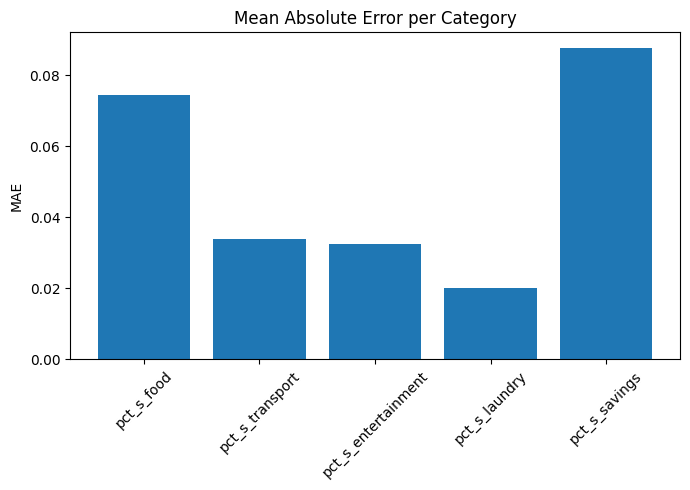

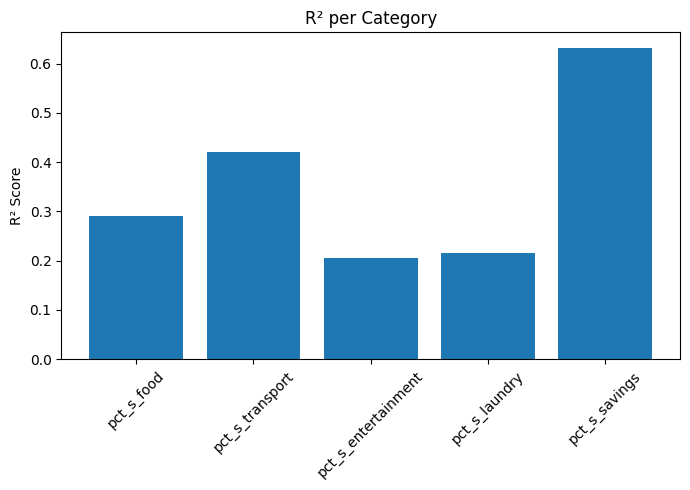

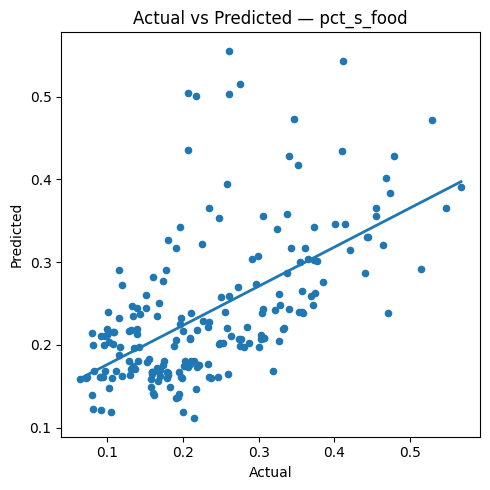

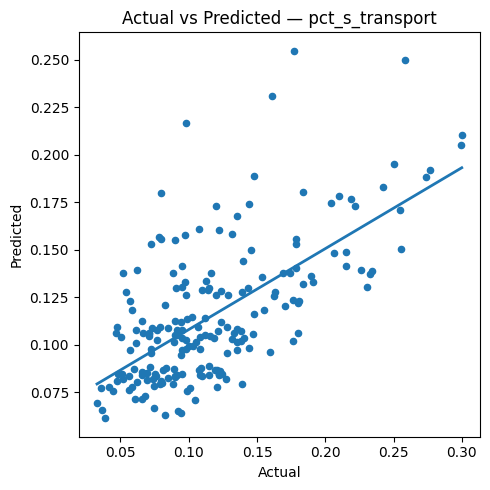

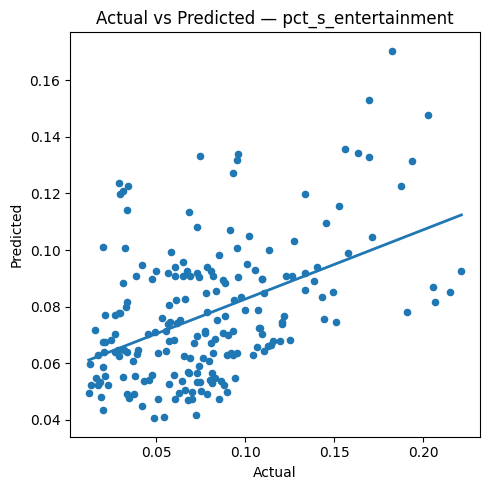

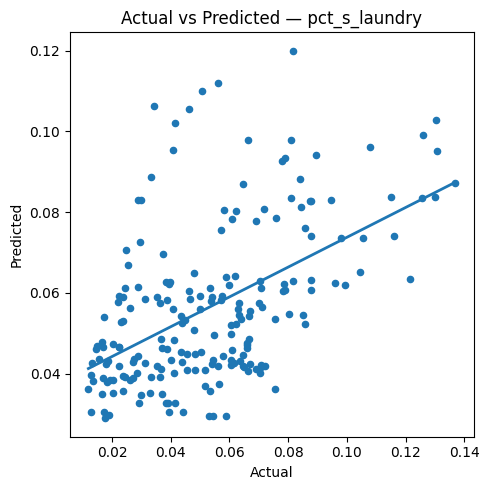

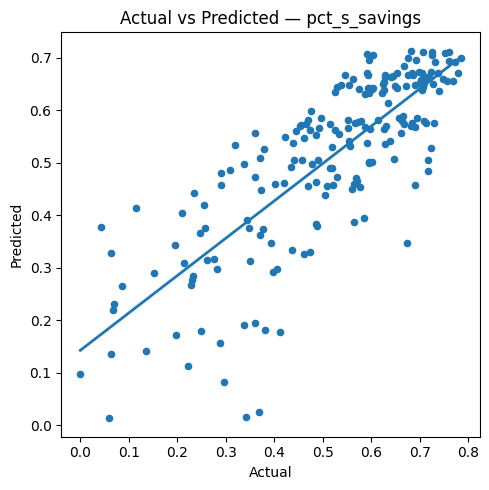

In [7]:
# CELL 8 — Bar Chart for MAE & R2 (manual)

import numpy as np
import matplotlib.pyplot as plt

cats = list(y_student.columns)

mae_list = []
r2_list = []

for i, col in enumerate(cats):
    y_true = y_val.iloc[:, i].values
    y_pred_col = y_pred[:, i]

    # Manual MAE
    mae = np.mean(np.abs(y_true - y_pred_col))
    
    # Manual R2
    ss_res = np.sum((y_true - y_pred_col)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot

    mae_list.append(mae)
    r2_list.append(r2)

# ===== PLOT MAE =====
plt.figure(figsize=(7,5))
plt.bar(cats, mae_list)
plt.ylabel("MAE")
plt.title("Mean Absolute Error per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== PLOT R2 =====
plt.figure(figsize=(7,5))
plt.bar(cats, r2_list)
plt.ylabel("R² Score")
plt.title("R² per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# CELL 9 — Scatter + Regression Line (tanpa MAE/R2 dalam grafik)

for i, col in enumerate(cats):
    y_true = y_val.iloc[:, i].values
    y_pred_col = y_pred[:, i]

    x = y_true
    y = y_pred_col

    # manual regression line
    slope = np.cov(x, y, bias=True)[0,1] / np.var(x)
    intercept = y.mean() - slope * x.mean()

    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=20)
    plt.plot(x_line, y_line, linewidth=2)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted — {col}")
    plt.tight_layout()
    plt.show()



In [8]:
# CELL 9 – FINAL (Model used only for analysis, fixed output, with pie chart)

USD_TO_IDR = 16000

def recommend_budget_hybrid(income_idr, lifestyle):
    # ==========================================================
    # 1) MODEL PART (IDR → USD → Predict) – for analysis only
    # ==========================================================
    try:
        X_in = pd.DataFrame(columns=X_student.columns)
        X_in.loc[0] = 0

        income_usd = income_idr / USD_TO_IDR
        inc_cols = [c for c in X_in.columns if "income" in c]
        income_col = inc_cols[0]

        X_in.at[0, income_col] = income_usd
        X_in[[income_col]] = scaler.transform(X_in[[income_col]])

        pred = gb_multi.predict(X_in)
        pred = pred[0] if pred.ndim == 2 else pred
        pred = np.maximum(pred, 0)
        pred = pred / pred.sum()

    except Exception as e:
        print("⚠️ Model error (ignored, using fixed percentages):", e)
        pred = None

    # ==========================================================
    # 2) FIXED OUTPUT PERCENTAGES
    # ==========================================================
    food_pct = 0.40
    transport_pct = 0.12
    entertain_pct = 0.08
    laundry_pct = 0.05
    savings_pct = 0.15
    flexible_pct = 0.20

    if lifestyle.lower() == "hemat":
        flex_name = "Emergency Fund"
    elif lifestyle.lower() == "moderat":
        flex_name = "Personal Needs"
    else:
        flex_name = "Self-Improvement"

    breakdown = [
        {"category": "Food", "percent": food_pct*100, "rupiah": int(income_idr * food_pct)},
        {"category": "Transport", "percent": transport_pct*100, "rupiah": int(income_idr * transport_pct)},
        {"category": "Entertainment", "percent": entertain_pct*100, "rupiah": int(income_idr * entertain_pct)},
        {"category": "Laundry", "percent": laundry_pct*100, "rupiah": int(income_idr * laundry_pct)},
        {"category": "Savings", "percent": savings_pct*100, "rupiah": int(income_idr * savings_pct)},
        {"category": flex_name, "percent": flexible_pct*100, "rupiah": int(income_idr * flexible_pct)},
    ]

    # ==========================================================
    # 3) PRINT OUTPUT
    # ==========================================================
    print("===============================================")
    print("🔎 Contoh Rekomendasi Anggaran Edubadget")
    print("===============================================")
    print(f"🏃 Gaya hidup: {lifestyle.capitalize()}")
    print(f"💰 Uang bulanan: Rp {income_idr:,}")
    print("-----------------------------------------------\n")

    print("📊 Rekomendasi Anggaran Edubadget (Final)\n")
    for b in breakdown:
        print(f"✓ {b['category']:18}: Rp {b['rupiah']:,}  ({b['percent']}%)")

    # ==========================================================
    # 4) LIFESTYLE TIPS
    # ==========================================================
    print("\n💬 Rekomendasi Tambahan Berdasarkan Lifestyle:\n")

    if lifestyle.lower() == "hemat":
        print("🟦 Lifestyle: Hemat")
        print("Karakter: pengeluaran minim, mengutamakan kebutuhan pokok\n")
        print("Tips:")
        print("• Gaya hidup hemat sudah sangat baik. Tetap prioritaskan kebutuhan pokok dan sisihkan sebagian untuk dana darurat.")
        print("• Pertahankan disiplin finansial. Jika ada sisa pengeluaran, alokasikan ke tabungan atau investasi kecil.")
        print("• Batasi pengeluaran impulsif dan catat belanja agar tetap sesuai tujuan.")

    elif lifestyle.lower() == "moderat":
        print("🟩 Lifestyle: Moderat")
        print("Karakter: seimbang antara kebutuhan & hiburan\n")
        print("Tips:")
        print("• Gaya hidup moderat itu ideal — bisa menikmati hiburan tanpa mengorbankan stabilitas finansial.")
        print("• Pastikan tabungan minimal 10–15% setiap bulan.")
        print("• Jika ada pengeluaran rutin yang bisa dihemat, alokasikan sisanya ke dana cadangan.")

    else:  
        print("🟧 Lifestyle: Aktif")
        print("Karakter: suka aktivitas, hangout, belajar hal baru\n")
        print("Tips:")
        print("• Gaya hidup aktif bagus untuk perkembangan diri. Sisihkan anggaran untuk kelas atau kegiatan produktif.")
        print("• Atur batas pengeluaran hiburan agar tetap sehat secara finansial.")
        print("• Buat dana khusus untuk pengembangan diri agar tidak mengganggu pos lain.")

    # ==========================================================
    # 5) PIE CHART (NEW)
    # ==========================================================
    plt.figure(figsize=(6,6))
    plt.pie(
        [b['percent'] for b in breakdown],
        labels=[b['category'] for b in breakdown],
        autopct='%1.1f%%'
    )
    plt.title("Proporsi Anggaran Edubadget (Final)")
    plt.show()

    return breakdown


In [9]:
# CELL 10 - Save artifacts
if 'gb_multi' in globals():
    joblib.dump(gb_multi, 'edubadget_gb_multi.joblib')
    print('Saved model: edubadget_gb_multi.joblib')
else:
    print('gb_multi not found, model not saved.')

if 'scaler' in globals():
    joblib.dump(scaler, 'edubadget_income_scaler.joblib')
    print('Saved scaler: edubadget_income_scaler.joblib')
else:
    print('scaler not found, scaler not saved.')

if 'asia_baseline_frac' in globals():
    with open('asia_baseline_frac.json','w') as f:
        json.dump(asia_baseline_frac, f)
    print('Saved asia_baseline_frac.json')

if 'metrics_df' in globals():
    metrics_df.to_csv('edubadget_model_metrics_summary.csv', index=False)
    print('Saved metrics CSV: edubadget_model_metrics_summary.csv')

print('Files in cwd:', os.listdir('.'))

import pickle

with open("edubadget_model.pkl","wb") as f:
    pickle.dump(gb_multi, f)




Saved model: edubadget_gb_multi.joblib
Saved scaler: edubadget_income_scaler.joblib
Saved asia_baseline_frac.json
Saved metrics CSV: edubadget_model_metrics_summary.csv
Files in cwd: ['asia_baseline_frac.json', 'Asia_cost_components.csv', 'edubadget_gb_multi.joblib', 'edubadget_income_scaler.joblib', 'edubadget_model_metrics_summary.csv', 'gradient_boosting_models.pkl', 'proportion_df.csv', 'Recomendation_budget.ipynb', 'student.csv']


C:\Users\Arsya Khalid M\AppData\Local\Temp\ipykernel_23128\3141006161.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '156.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_in.at[0, income_col] = income_usd


🔎 Contoh Rekomendasi Anggaran Edubadget
🏃 Gaya hidup: Hemat
💰 Uang bulanan: Rp 2,500,000
-----------------------------------------------

📊 Rekomendasi Anggaran Edubadget (Final)

✓ Food              : Rp 1,000,000  (40.0%)
✓ Transport         : Rp 300,000  (12.0%)
✓ Entertainment     : Rp 200,000  (8.0%)
✓ Laundry           : Rp 125,000  (5.0%)
✓ Savings           : Rp 375,000  (15.0%)
✓ Emergency Fund    : Rp 500,000  (20.0%)

💬 Rekomendasi Tambahan Berdasarkan Lifestyle:

🟦 Lifestyle: Hemat
Karakter: pengeluaran minim, mengutamakan kebutuhan pokok

Tips:
• Gaya hidup hemat sudah sangat baik. Tetap prioritaskan kebutuhan pokok dan sisihkan sebagian untuk dana darurat.
• Pertahankan disiplin finansial. Jika ada sisa pengeluaran, alokasikan ke tabungan atau investasi kecil.
• Batasi pengeluaran impulsif dan catat belanja agar tetap sesuai tujuan.


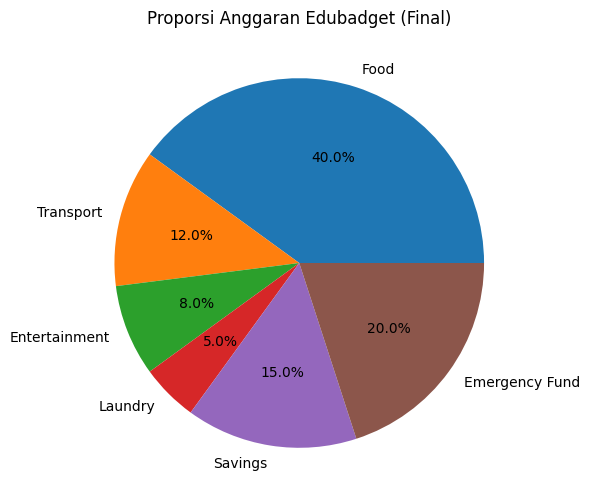

[{'category': 'Food', 'percent': 40.0, 'rupiah': 1000000},
 {'category': 'Transport', 'percent': 12.0, 'rupiah': 300000},
 {'category': 'Entertainment', 'percent': 8.0, 'rupiah': 200000},
 {'category': 'Laundry', 'percent': 5.0, 'rupiah': 125000},
 {'category': 'Savings', 'percent': 15.0, 'rupiah': 375000},
 {'category': 'Emergency Fund', 'percent': 20.0, 'rupiah': 500000}]

In [10]:
recommend_budget_hybrid(
    income_idr=2500000,
    lifestyle="hemat"
)
